In [1]:
using LinearAlgebra
using PyPlot
using Random
using NPZ
using Dates

# projection function onto the design space
function proj(x)
    a = x[1:p*k]
    b = x[(1:k) .+ (p*k)]
    
    a = reshape(a,p,k)
    a = max.(a,design[:,1])
    a = min.(a,design[:,2])
    a = reshape(a,p*k)
    
    u = sort(b, rev=true)
    j = k
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    
    return [a;b]
end

function proj2(x)
    x = max.(x,design2[:,1])
    x = min.(x,design2[:,2])
    return x
end

function pso2(xx,lp2)
    #initialize
    #srand(1992)
    path2 = zeros(niter2)
    tau2 = 0.9:(-0.5/niter2):0.4
    v2 = zeros(nptc2, p2)
    ptc2 = rand(nptc2, p2)
    for j2 in 1:p2
            ptc2[:,j2] = (design2[j2,2] - design2[j2,1]) * ptc2[:,j2] .+ design2[j2,1]
    end
    pbesth2 = zeros(nptc2)
    pbest2 = ptc2
    for j2 in 1:nptc2
        pbesth2[j2] = obj(xx,pbest2[j2,:])
    end
    gbesth2 = findmax(pbesth2)[1]
    gbest2 = pbest2[findmax(pbesth2)[2],:]

    #iterate
    for i2 in 1:niter2 # iteration number
        for j2 in 1:nptc2 # particle number
            g12 = rand(p2)
            g22 = rand(p2)
            v2[j2,:] = tau2[i2] .*v2[j2,:] + lp2 .* g12 .*(pbest2[j2,:]-ptc2[j2,:]) + lp2 .* g22 .*(gbest2-ptc2[j2,:])
            ptc2[j2,:] = ptc2[j2,:] + v2[j2,:]
            ptc2[j2,:] = proj2(ptc2[j2,:])
            fit2 = obj(xx,ptc2[j2,:])
            if fit2 > gbesth2
                gbesth2 = pbesth2[j2] = fit2
                gbest2 = pbest2[j2,:] = ptc2[j2,:]
            elseif fit2 > pbesth2[j2]
                pbesth2[j2] = fit2
                pbest2[j2,:] = ptc2[j2,:]
            end
        end
        path2[i2] = gbesth2
    end
    return [gbesth2; gbest2; path2]
end

function pso(lp,lp2)
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, p*k+k)
    x = rand(nptc,p*k)
    for j in 1:p
        x[:,p*(1:k).+(j-p)] = (design[j,2]-design[j,1]) * x[:,p*(1:k).+(j-p)] .+ design[j,1]
    end    
    w = randexp(nptc,k)
    for j in 1:nptc
            w[j,:] = w[j,:] ./ sum(w[j,:])
    end
    ptc = hcat(x,w)
    pbest = ptc
    pbesth = zeros(nptc)
    for j in 1:nptc
        pbesth[j] = pso2(pbest[j,:],lp2)[1]
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]
    
    tbest = zeros(p2)
    
    #iterate
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            g1 = rand(p*k+k)
            g2 = rand(p*k+k)
            v[j,:] = tau[i] .*v[j,:] + lp .* g1 .*(pbest[j,:]-ptc[j,:]) + lp .* g2 .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:])
            fit = pso2(ptc[j,:],lp2)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
                tbest = fit[(1:p2) .+ 1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
        print(".")
    end
    
    return [gbesth; gbest; tbest; path]
end

pso (generic function with 1 method)

In [2]:
function obj(eta, theta)
    mat = zeros(2,2)
    b = theta[2]
    a = theta[1]
    for i in 1:k
        m0 = zeros(2)
        s = eta[i]
        w = eta[i+k]
        m0[1] = b
        m0[2] = -s+a
        p = 1/(1+exp(-b*(s-a))) 
        mat = mat + w * p*(1-p) * m0*m0' 
    end
    if det(mat) < 10.0^-6
        return Inf
    else
        return -log(det(mat))
    end
end

obj (generic function with 1 method)

In [3]:
param = npzread("ex32b.npy")
param = param[2:13]

12-element Array{Float64,1}:
  0.6617733121951783   
  1.9306676662226094   
 -0.27607172988866646  
  5.0                  
  2.8771180339567697   
  3.785895989477358    
  0.24521140305222827  
  0.22409024686769308  
  0.18583516185812232  
  1.4339884201200014e-5
  0.18471677535153203  
  0.1601320729862232   

In [4]:
# outer loop
k = 6
nptc = 512
niter = 200
design = [-5 5]
p = size(design)[1]

# inner loop
nptc2 = 256
niter2 = 100
design2 = [0 3.5 ; 1 3.5]
p2 = size(design2)[1]

nsim = 1000
output = zeros(nsim, 1+p2+niter2)

println("##### Simulation starts at $(Dates.Time(Dates.now()))")

for rp in 1:nsim
    output[rp,:] = pso2(param,2)
    npzwrite("eik1.npy",output)
    println("##### Simulation $(rp)/$(nsim) complete, $(Dates.Time(Dates.now()))")
end

println("########## SIMULATION FINISHED, CHECK THE RESULTS, $(Dates.Time(Dates.now()))")

##### Simulation starts at 13:37:12.822
##### Simulation 1/1000 complete, 13:37:21.43
##### Simulation 2/1000 complete, 13:37:22.749
##### Simulation 3/1000 complete, 13:37:23.598
##### Simulation 4/1000 complete, 13:37:24.738
##### Simulation 5/1000 complete, 13:37:25.929
##### Simulation 6/1000 complete, 13:37:26.919
##### Simulation 7/1000 complete, 13:37:27.679
##### Simulation 8/1000 complete, 13:37:28.407
##### Simulation 9/1000 complete, 13:37:29.259
##### Simulation 10/1000 complete, 13:37:30.329
##### Simulation 11/1000 complete, 13:37:31.397
##### Simulation 12/1000 complete, 13:37:32.829
##### Simulation 13/1000 complete, 13:37:33.672
##### Simulation 14/1000 complete, 13:37:34.585
##### Simulation 15/1000 complete, 13:37:35.517
##### Simulation 16/1000 complete, 13:37:36.83
##### Simulation 17/1000 complete, 13:37:37.555
##### Simulation 18/1000 complete, 13:37:38.214
##### Simulation 19/1000 complete, 13:37:39.162
##### Simulation 20/1000 complete, 13:37:39.891
##### Simul

##### Simulation 170/1000 complete, 13:40:23.382
##### Simulation 171/1000 complete, 13:40:24.675
##### Simulation 172/1000 complete, 13:40:25.996
##### Simulation 173/1000 complete, 13:40:27.357
##### Simulation 174/1000 complete, 13:40:28.746
##### Simulation 175/1000 complete, 13:40:29.915
##### Simulation 176/1000 complete, 13:40:30.706
##### Simulation 177/1000 complete, 13:40:31.616
##### Simulation 178/1000 complete, 13:40:32.782
##### Simulation 179/1000 complete, 13:40:33.668
##### Simulation 180/1000 complete, 13:40:34.719
##### Simulation 181/1000 complete, 13:40:35.616
##### Simulation 182/1000 complete, 13:40:36.699
##### Simulation 183/1000 complete, 13:40:37.862
##### Simulation 184/1000 complete, 13:40:39.286
##### Simulation 185/1000 complete, 13:40:40.556
##### Simulation 186/1000 complete, 13:40:41.833
##### Simulation 187/1000 complete, 13:40:43.114
##### Simulation 188/1000 complete, 13:40:44.406
##### Simulation 189/1000 complete, 13:40:45.651
##### Simulation 190

##### Simulation 338/1000 complete, 13:43:29.55
##### Simulation 339/1000 complete, 13:43:30.878
##### Simulation 340/1000 complete, 13:43:31.818
##### Simulation 341/1000 complete, 13:43:32.641
##### Simulation 342/1000 complete, 13:43:34.032
##### Simulation 343/1000 complete, 13:43:35.113
##### Simulation 344/1000 complete, 13:43:36.053
##### Simulation 345/1000 complete, 13:43:36.776
##### Simulation 346/1000 complete, 13:43:38.002
##### Simulation 347/1000 complete, 13:43:38.799
##### Simulation 348/1000 complete, 13:43:39.991
##### Simulation 349/1000 complete, 13:43:41.397
##### Simulation 350/1000 complete, 13:43:42.594
##### Simulation 351/1000 complete, 13:43:43.853
##### Simulation 352/1000 complete, 13:43:44.817
##### Simulation 353/1000 complete, 13:43:45.454
##### Simulation 354/1000 complete, 13:43:46.434
##### Simulation 355/1000 complete, 13:43:47.616
##### Simulation 356/1000 complete, 13:43:48.57
##### Simulation 357/1000 complete, 13:43:49.614
##### Simulation 358/1

##### Simulation 506/1000 complete, 13:46:32.54
##### Simulation 507/1000 complete, 13:46:33.703
##### Simulation 508/1000 complete, 13:46:34.992
##### Simulation 509/1000 complete, 13:46:36.24
##### Simulation 510/1000 complete, 13:46:37.472
##### Simulation 511/1000 complete, 13:46:38.741
##### Simulation 512/1000 complete, 13:46:39.846
##### Simulation 513/1000 complete, 13:46:40.631
##### Simulation 514/1000 complete, 13:46:41.519
##### Simulation 515/1000 complete, 13:46:42.405
##### Simulation 516/1000 complete, 13:46:43.237
##### Simulation 517/1000 complete, 13:46:44.429
##### Simulation 518/1000 complete, 13:46:45.444
##### Simulation 519/1000 complete, 13:46:46.579
##### Simulation 520/1000 complete, 13:46:47.553
##### Simulation 521/1000 complete, 13:46:48.516
##### Simulation 522/1000 complete, 13:46:49.581
##### Simulation 523/1000 complete, 13:46:50.366
##### Simulation 524/1000 complete, 13:46:51.318
##### Simulation 525/1000 complete, 13:46:52.272
##### Simulation 526/1

##### Simulation 674/1000 complete, 13:49:30.992
##### Simulation 675/1000 complete, 13:49:31.981
##### Simulation 676/1000 complete, 13:49:33.077
##### Simulation 677/1000 complete, 13:49:34.133
##### Simulation 678/1000 complete, 13:49:34.775
##### Simulation 679/1000 complete, 13:49:36.038
##### Simulation 680/1000 complete, 13:49:37.419
##### Simulation 681/1000 complete, 13:49:38.529
##### Simulation 682/1000 complete, 13:49:39.537
##### Simulation 683/1000 complete, 13:49:40.653
##### Simulation 684/1000 complete, 13:49:41.564
##### Simulation 685/1000 complete, 13:49:42.718
##### Simulation 686/1000 complete, 13:49:43.635
##### Simulation 687/1000 complete, 13:49:44.548
##### Simulation 688/1000 complete, 13:49:45.855
##### Simulation 689/1000 complete, 13:49:46.999
##### Simulation 690/1000 complete, 13:49:48.393
##### Simulation 691/1000 complete, 13:49:49.388
##### Simulation 692/1000 complete, 13:49:50.152
##### Simulation 693/1000 complete, 13:49:50.941
##### Simulation 694

##### Simulation 842/1000 complete, 13:52:35.706
##### Simulation 843/1000 complete, 13:52:36.692
##### Simulation 844/1000 complete, 13:52:37.886
##### Simulation 845/1000 complete, 13:52:38.518
##### Simulation 846/1000 complete, 13:52:39.226
##### Simulation 847/1000 complete, 13:52:40
##### Simulation 848/1000 complete, 13:52:40.882
##### Simulation 849/1000 complete, 13:52:41.952
##### Simulation 850/1000 complete, 13:52:42.83
##### Simulation 851/1000 complete, 13:52:43.977
##### Simulation 852/1000 complete, 13:52:44.61
##### Simulation 853/1000 complete, 13:52:45.475
##### Simulation 854/1000 complete, 13:52:46.304
##### Simulation 855/1000 complete, 13:52:47.299
##### Simulation 856/1000 complete, 13:52:48.073
##### Simulation 857/1000 complete, 13:52:48.915
##### Simulation 858/1000 complete, 13:52:49.747
##### Simulation 859/1000 complete, 13:52:50.902
##### Simulation 860/1000 complete, 13:52:51.847
##### Simulation 861/1000 complete, 13:52:53.059
##### Simulation 862/1000 

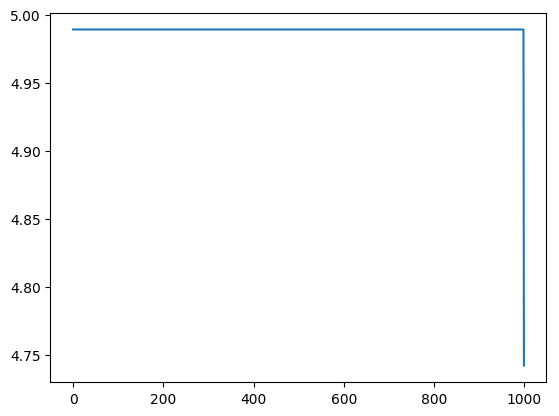

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f712772cc50>

In [5]:
plot(sort(output[:,1],rev=true))

In [6]:
using StatsBase
summarystats(output[:,1])

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           4.989095
Minimum:        4.741982
1st Quartile:   4.989342
Median:         4.989342
3rd Quartile:   4.989342
Maximum:        4.989342


In [7]:
mean(output[:,1] .< mean(output[:,1]))

0.001

In [8]:
function showsummary(x)
    support = reshape(x[(1:p*k).+1],p,k)
    weight = x[(1:k) .+ (p*k+1)]
    theta = x[(1:p2) .+ (p*k+k+1)]
    optimum = x[1]
    return [support, weight, theta, optimum]
end

function showplot(x)
    path = x[(1:niter) .+ (length(x)-niter)]
    return plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
end

function showsummary2(x)
    theta = x[(1:p2).+1]
    optimum = x[1]
    return [theta, optimum]
end

function showplot2(x)
    path = x[(1:niter2) .+ (length(x)-niter2)]
    return plot(1:niter2, path, color="red", linewidth=2.0, linestyle="solid")
end

showplot2 (generic function with 1 method)

In [9]:
loc = findmin(output[:,1])[2]
showsummary2(output[loc,:])

2-element Array{Any,1}:
  [0.719085, 3.5]
 4.74198195091795